# Example Usage of EQTransformer from seisbench
This notebook is mostly an uncommented version of the “03a_training_phasenet” notebook from the seisbench repository.

In [1]:
import seisbench.generate as sbg
import seisbench.models as sbm

from seisbench.data import WaveformDataset
from seisbench.models import EQTransformer
from seisbench.util import worker_seeding

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from tqdm import tqdm
import sys


Load the 100Samples dataset from the EQTransformer repository but transformed into seisbench-compatible format.

In [2]:
example_data = WaveformDataset("data/STEAD/example/seisbench")


Instantiate a version of seisbench’s EQTransformer

In [3]:
eqt = EQTransformer()
eqt = sbm.EQTransformer.from_pretrained("original")


This part is slightly weird, but the *data* contains information about what is training, validation, and test, already.
In this case, I just randomly designated 81 samples as training data, 9 as dev/validation data, and the remaining 10 as test data; see also the “Convert Example Data to Seisbench Format” notebook.

In [4]:
train, dev, test = example_data.train_dev_test()


Rename the label columns.

In [5]:
phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_s_arrival_sample": "S"
}


Perform (minimal) data augmentation.  I assume (but did not test) that `ChangeDtype` is necessary for the code to run; `ProbabilisticLabeller` provides the probability curves below, but I do not know how they are calculated.

In [6]:
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(train)

augmentations = [
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, sigma=30, dim=0)
]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)


In [7]:
sample = train_generator[np.random.randint(len(train_generator))]


In [8]:
batch_size = 100 #
num_workers = 1  # The number of threads used for loading data

train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding)
dev_loader = DataLoader(dev_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)


Train the model.  Negative loss should not be possible, I think, but this could just be an issue with the small sample size.

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


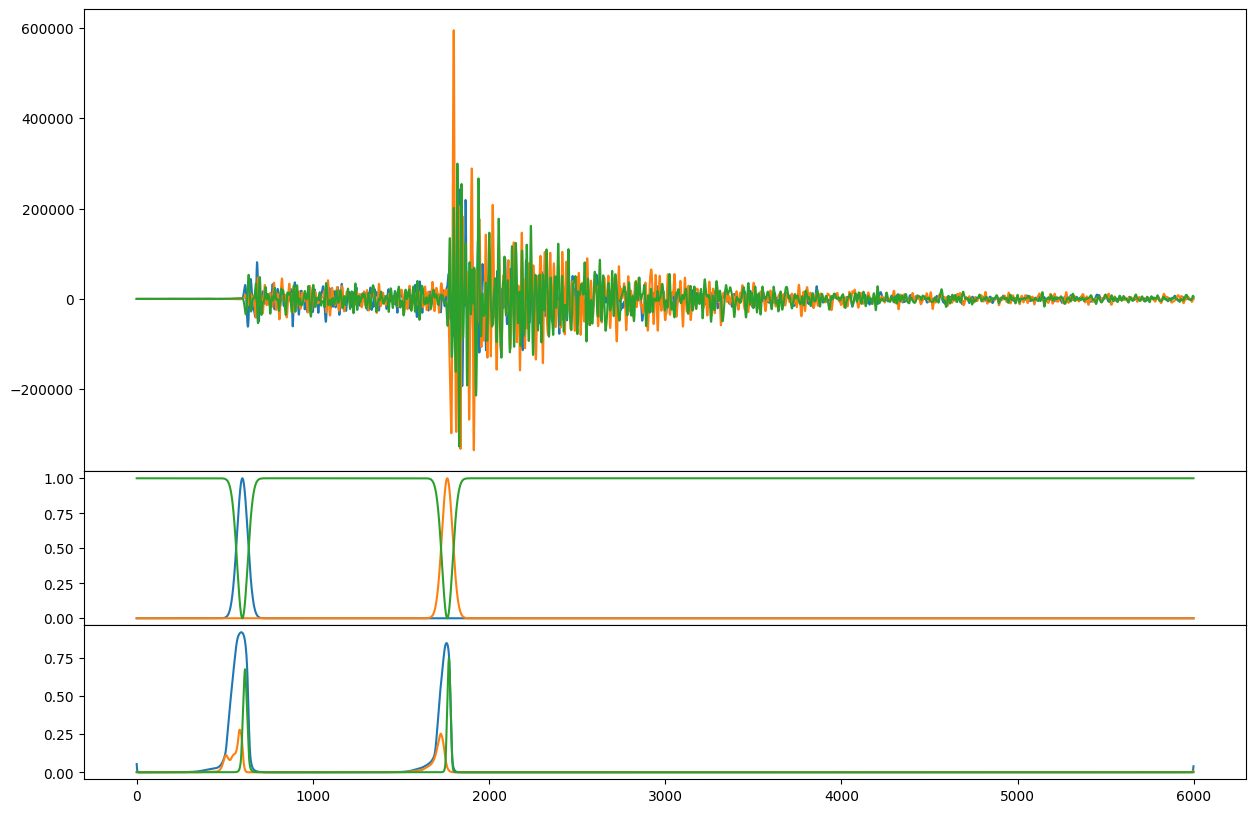

In [9]:
sample = dev_generator[np.random.randint(len(dev_generator))]
sample = dev_generator[0]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

eqt.eval()  # close the model for evaluation

with torch.no_grad():
    pred = eqt(torch.tensor(sample["X"], device=eqt.device).unsqueeze(0))  # Add a fake batch dimension
    pred = torch.cat(pred).cpu().numpy()
    # pred = pred.cpu().numpy()

axs[2].plot(pred.T)


In [10]:
eqt.eval()
for m in eqt.modules():
  if m.__class__.__name__.startswith('Dropout'):
    m.train()


In [11]:
sample = dev_generator[0]

dropout_predictions = np.empty((0, 3, 6000))
for i in tqdm(range(1000)):
  with torch.no_grad():
    output = eqt(torch.tensor(sample["X"], device=eqt.device).unsqueeze(0))
    output = torch.cat(output).unsqueeze(0).cpu().numpy()
  dropout_predictions = np.vstack((dropout_predictions, output))


100%|██████████| 1000/1000 [02:51<00:00,  5.82it/s]


In [12]:
# Calculating mean across multiple MCD forward passes
mean = np.mean(dropout_predictions, axis=0)

# Calculating variance across multiple MCD forward passes
variance = np.var(dropout_predictions, axis=0)


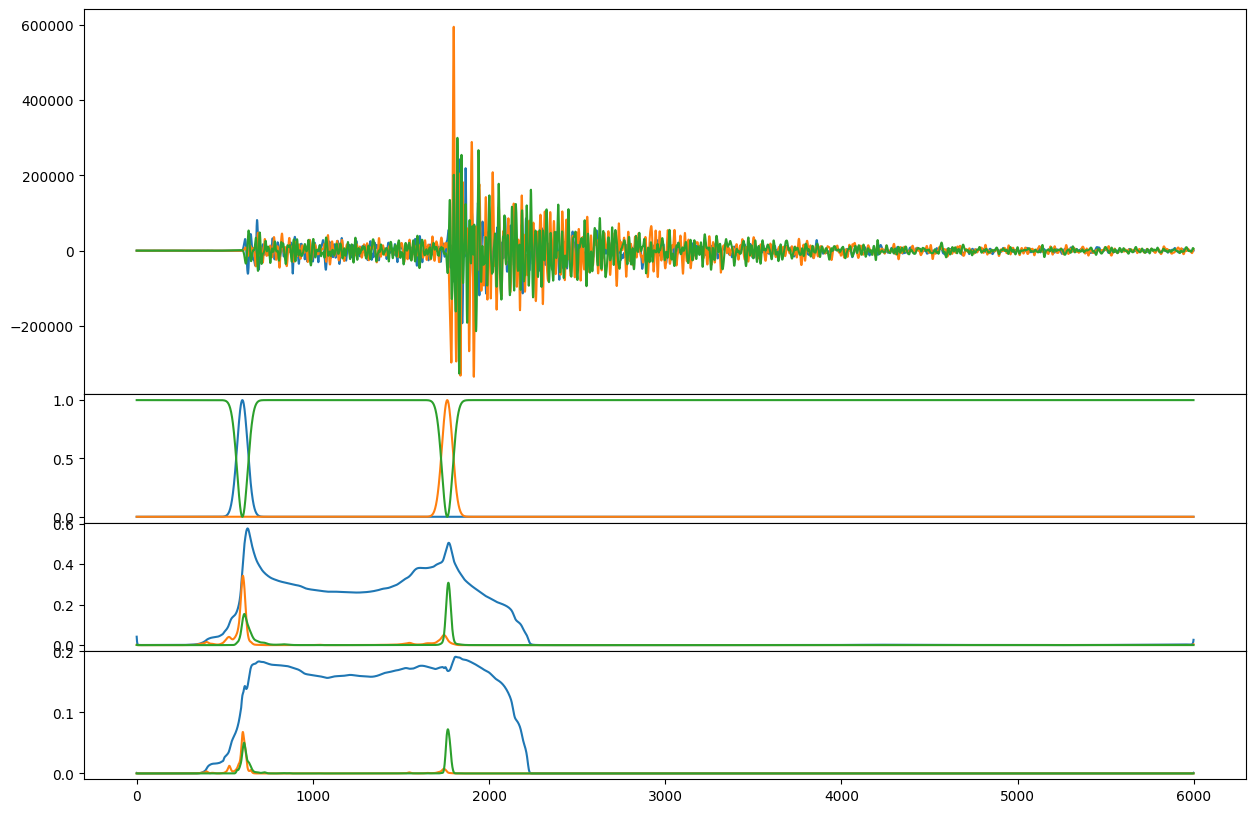

In [13]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(4, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

eqt.eval()  # close the model for evaluation

axs[2].plot(mean.T)
axs[3].plot(variance.T)


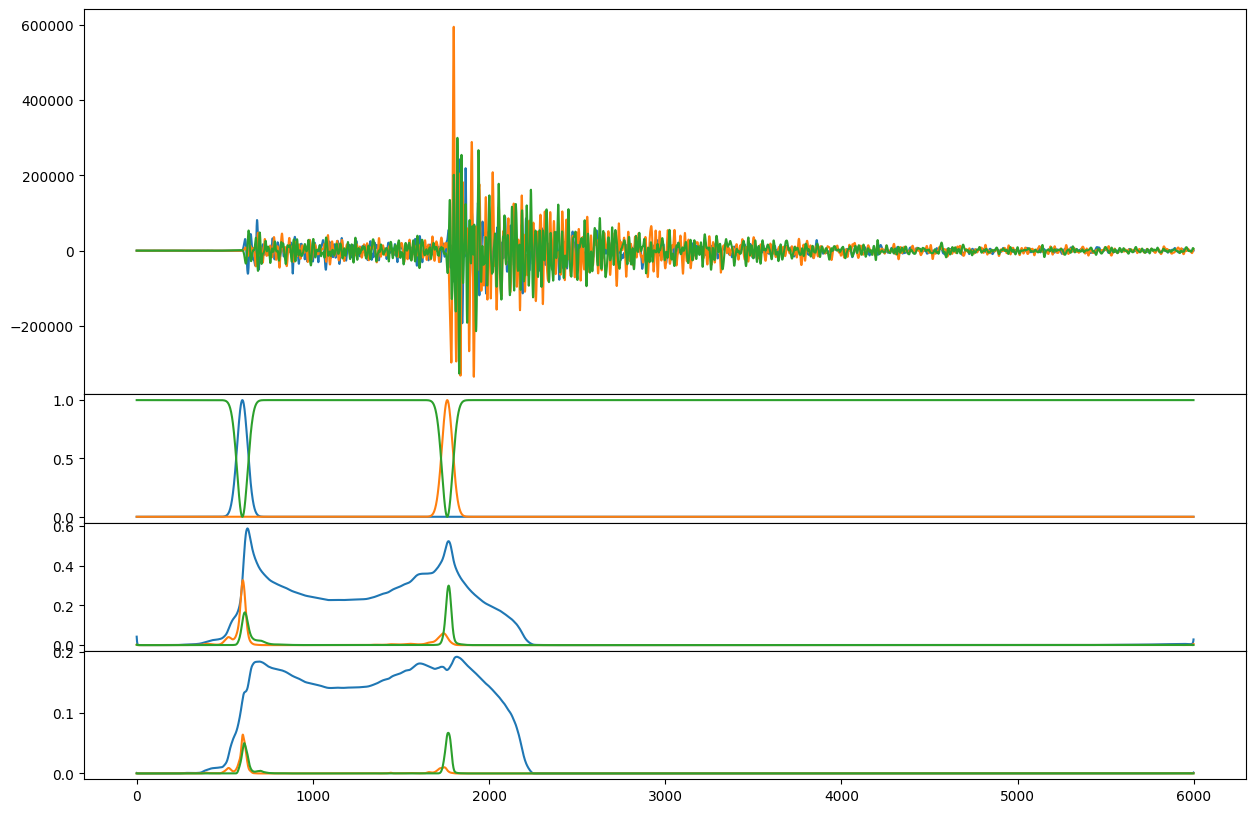

In [13]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(4, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

eqt.eval()  # close the model for evaluation

axs[2].plot(mean.T)
axs[3].plot(variance.T)
